In [1]:
# Training variables
rolling_mean = 30
lag = 10
# Only use time-series features

## Import data from AWS S3

In [2]:
import sys
sys.path.insert(0, '/home/khiem/Dropbox/Education/Drexel/DSCI-591/Project/Walmart-Strategic-Sales-Forecasting')

In [3]:
import boto3
import pandas as pd

bucket = 'dsci-632'

s3 = boto3.client('s3')
obj = s3.get_object(Bucket="dsci-632", Key="CA_1_sales_data.csv")
df = pd.read_csv(obj['Body'], index_col=0, parse_dates=True) # 'Body' is a keyword
print(df.head())

            wm_yr_wk  wday  month  year event_name_1 event_type_1  \
2011-01-29     11101     1      1  2011         None         None   
2011-01-30     11101     2      1  2011         None         None   
2011-01-31     11101     3      1  2011         None         None   
2011-02-01     11101     4      2  2011         None         None   
2011-02-02     11101     5      2  2011         None         None   

           event_name_2 event_type_2      cpi  unemployment_rate  gas_price  \
2011-01-29         None         None  221.187                9.1      3.163   
2011-01-30         None         None  221.187                9.1      3.163   
2011-01-31         None         None  221.187                9.1      3.155   
2011-02-01         None         None  221.898                9.0      3.155   
2011-02-02         None         None  221.898                9.0      3.155   

            snap_ca  ca_walmart  ca_hobbies  ca_household  ca_foods  \
2011-01-29        0       39.50       2

## Data Processing

In [4]:
from data_processing.pre_modeling import pre_modeling

df_processed = pre_modeling(df)

## Data Analysis

In [5]:
timeseries_cols = ['cpi', 'unemployment_rate', 'gas_price', 'ca_walmart', 'ca_hobbies', 'ca_household', 'ca_foods', 'median_price', 'min_price', 'max_price']
time_cols = ['wm_yr_wk', 'wday', 'day', 'month', 'year']
target_col = ['store_sales']
cat_cols = [col for col in df_processed.columns if col not in timeseries_cols + time_cols + target_col] # extract the remaining columns

In [6]:
df_used = df_processed[timeseries_cols+time_cols+cat_cols+target_col]
df_used = df_used.rolling(rolling_mean).mean().dropna()

In [7]:
nobs = 30
df_original = df_used
df_test = df_used[-nobs:]
df_train = df_used[0:-nobs]

print(df_train.columns)

Index(['cpi', 'unemployment_rate', 'gas_price', 'ca_walmart', 'ca_hobbies',
       'ca_household', 'ca_foods', 'median_price', 'min_price', 'max_price',
       'wm_yr_wk', 'wday', 'day', 'month', 'year', 'snap_ca',
       'event_name_1_chanukah end', 'event_name_1_christmas',
       'event_name_1_cinco de mayo', 'event_name_1_columbusday',
       'event_name_1_easter', 'event_name_1_eid al-fitr',
       'event_name_1_eidaladha', 'event_name_1_father's day',
       'event_name_1_halloween', 'event_name_1_independenceday',
       'event_name_1_laborday', 'event_name_1_lentstart',
       'event_name_1_lentweek2', 'event_name_1_martinlutherkingday',
       'event_name_1_memorialday', 'event_name_1_mother's day',
       'event_name_1_nbafinalsend', 'event_name_1_nbafinalsstart',
       'event_name_1_newyear', 'event_name_1_none',
       'event_name_1_orthodoxchristmas', 'event_name_1_orthodoxeaster',
       'event_name_1_pesach end', 'event_name_1_presidentsday',
       'event_name_1_purim 

In [8]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 

    if p_value > sig:
        return True
    else:
        return False

def adfuller_test_all(df, sig=0.05):
    non_stationary = []
    stationary = []
    for name, column in df_train.iteritems():
        if adfuller_test(column, name=column.name):
            non_stationary.append(column.name)
        else:
            stationary.append(column.name)

    print('Non-stationary:', non_stationary)
    print('Stationary:', stationary)

adfuller_test_all(df_train)

Non-stationary: ['cpi', 'unemployment_rate', 'gas_price', 'median_price', 'min_price', 'max_price', 'wm_yr_wk', 'year', 'store_sales']
Stationary: ['ca_walmart', 'ca_hobbies', 'ca_household', 'ca_foods', 'wday', 'day', 'month', 'snap_ca', 'event_name_1_chanukah end', 'event_name_1_christmas', 'event_name_1_cinco de mayo', 'event_name_1_columbusday', 'event_name_1_easter', 'event_name_1_eid al-fitr', 'event_name_1_eidaladha', "event_name_1_father's day", 'event_name_1_halloween', 'event_name_1_independenceday', 'event_name_1_laborday', 'event_name_1_lentstart', 'event_name_1_lentweek2', 'event_name_1_martinlutherkingday', 'event_name_1_memorialday', "event_name_1_mother's day", 'event_name_1_nbafinalsend', 'event_name_1_nbafinalsstart', 'event_name_1_newyear', 'event_name_1_none', 'event_name_1_orthodoxchristmas', 'event_name_1_orthodoxeaster', 'event_name_1_pesach end', 'event_name_1_presidentsday', 'event_name_1_purim end', 'event_name_1_ramadan starts', 'event_name_1_stpatricksday', 

In [9]:
df_train = df_train.diff().dropna()
adfuller_test_all(df_train)

Non-stationary: []
Stationary: ['cpi', 'unemployment_rate', 'gas_price', 'ca_walmart', 'ca_hobbies', 'ca_household', 'ca_foods', 'median_price', 'min_price', 'max_price', 'wm_yr_wk', 'wday', 'day', 'month', 'year', 'snap_ca', 'event_name_1_chanukah end', 'event_name_1_christmas', 'event_name_1_cinco de mayo', 'event_name_1_columbusday', 'event_name_1_easter', 'event_name_1_eid al-fitr', 'event_name_1_eidaladha', "event_name_1_father's day", 'event_name_1_halloween', 'event_name_1_independenceday', 'event_name_1_laborday', 'event_name_1_lentstart', 'event_name_1_lentweek2', 'event_name_1_martinlutherkingday', 'event_name_1_memorialday', "event_name_1_mother's day", 'event_name_1_nbafinalsend', 'event_name_1_nbafinalsstart', 'event_name_1_newyear', 'event_name_1_none', 'event_name_1_orthodoxchristmas', 'event_name_1_orthodoxeaster', 'event_name_1_pesach end', 'event_name_1_presidentsday', 'event_name_1_purim end', 'event_name_1_ramadan starts', 'event_name_1_stpatricksday', 'event_name_1

In [10]:
from statsmodels.tsa.api import VAR

df_train_fit = df_train[timeseries_cols+target_col]
model = VAR(df_train_fit)
x = model.select_order(maxlags=12)
x.summary()

/home/khiem/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-66.03,-65.99,2.114e-29,-66.01
1,-83.58,-83.19,5.010e-37,-83.44
2,-84.25,-83.50*,2.570e-37,-83.98
3,-84.41,-83.30,2.204e-37,-84.00
4,-84.73,-83.27,1.589e-37,-84.19
5,-84.78,-82.95,1.523e-37,-84.10
6,-85.10,-82.92,1.103e-37,-84.29
7,-85.37,-82.83,8.415e-38,-84.43
8,-86.06,-83.16,4.203e-38,-85.00*
9,-86.03,-82.77,4.360e-38,-84.83


In [11]:
model_fitted = model.fit(lag)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 08, Aug, 2022
Time:                     00:57:40
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -82.4616
Nobs:                     1871.00    HQIC:                  -84.7426
Log likelihood:           52539.3    FPE:                4.16442e-38
AIC:                     -86.0732    Det(Omega_mle):     2.20915e-38
--------------------------------------------------------------------
Results for equation cpi
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.000678         0.000153            4.422           0.000
L1.cpi                        0.719978         0.024171           29.787           0.000
L1.unemployment_rate         -

In [12]:
print(model_fitted.params["store_sales"])

const                      0.695494
L1.cpi                   -53.096092
L1.unemployment_rate     216.258092
L1.gas_price             190.346150
L1.ca_walmart              5.112104
                           ...     
L10.ca_foods               0.200932
L10.median_price        3820.864117
L10.min_price            752.711011
L10.max_price             25.203647
L10.store_sales            0.040593
Name: store_sales, Length: 111, dtype: float64


In [13]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = df_train_fit.values[-lag_order:]
forecast_input

10


array([[ 3.04000000e-02,  3.33333333e-03,  3.70000000e-03,
         1.68000000e-01, -3.24000000e-01, -4.93666667e-01,
         4.82666667e-01,  4.44089210e-16,  0.00000000e+00,
         7.10542736e-15, -2.37333333e+01],
       [ 3.04000000e-02,  3.33333333e-03,  3.70000000e-03,
         1.44000000e-01,  2.50000000e-02,  3.02333333e-01,
         2.80333333e-01,  0.00000000e+00,  0.00000000e+00,
        -7.10542736e-15,  6.00000000e+00],
       [ 3.04000000e-02,  3.33333333e-03,  3.70000000e-03,
         2.40000000e-01, -3.86666667e-02,  5.22000000e-01,
         3.55000000e-01, -4.44089210e-16,  0.00000000e+00,
         0.00000000e+00,  1.31666667e+01],
       [ 3.04000000e-02,  3.33333333e-03,  3.70000000e-03,
         4.56000000e-01,  1.01333333e-01, -2.20666667e-01,
         4.65333333e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  7.02666667e+01],
       [ 3.04000000e-02,  3.33333333e-03,  3.70000000e-03,
         4.92000000e-01, -3.82666667e-01,  2.13333333e-02,
  

In [14]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_original.index[-nobs:], columns=df_train_fit.columns + '_1d')
df_forecast["store_sales_1d"]

2016-04-23    61.720613
2016-04-24    48.110743
2016-04-25   -37.809592
2016-04-26   -69.070624
2016-04-27   -25.936226
2016-04-28     3.045335
2016-04-29    19.674021
2016-04-30    61.243600
2016-05-01    45.078335
2016-05-02   -35.224067
2016-05-03   -64.073133
2016-05-04   -26.164096
2016-05-05     1.814955
2016-05-06    22.664003
2016-05-07    57.146328
2016-05-08    41.431007
2016-05-09   -31.523695
2016-05-10   -60.485763
2016-05-11   -27.154618
2016-05-12     2.015382
2016-05-13    24.213874
2016-05-14    53.886928
2016-05-15    37.957667
2016-05-16   -28.288181
2016-05-17   -57.259751
2016-05-18   -27.643291
2016-05-19     2.533374
2016-05-20    25.384026
2016-05-21    51.008699
2016-05-22    34.871427
Name: store_sales_1d, dtype: float64

In [15]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(df_original[0:-nobs][timeseries_cols+target_col], df_forecast)        
df_results.head(10)

,cpi_1d,unemployment_rate_1d,gas_price_1d,ca_walmart_1d,ca_hobbies_1d,ca_household_1d,ca_foods_1d,median_price_1d,min_price_1d,max_price_1d,...,unemployment_rate_forecast,gas_price_forecast,ca_walmart_forecast,ca_hobbies_forecast,ca_household_forecast,ca_foods_forecast,median_price_forecast,min_price_forecast,max_price_forecast,store_sales_forecast
2016-04-23,0.029930,0.002939,0.004233,0.549711,0.103650,-0.119754,0.376196,0.000065,7.636189e-06,-0.001882,...,5.076272,2.181733,27.957711,29.095983,38.582246,54.598529,3.480065,0.230008,29.968118,4593.287280
2016-04-24,0.030861,0.002219,0.004263,0.539921,0.069542,-0.118128,0.491280,0.000080,3.919087e-05,-0.001751,...,5.078491,2.185996,28.497632,29.165525,38.464118,55.089809,3.480146,0.230047,29.966367,4641.398023
2016-04-25,0.030118,0.002007,0.005570,0.043699,-0.088591,0.088330,0.545885,0.000081,5.375917e-06,0.000049,...,5.080498,2.191566,28.541332,29.076935,38.552448,55.635694,3.480227,0.230052,29.966416,4603.588430
2016-04-26,0.029537,0.001885,0.005423,-0.128251,-0.209931,0.141892,0.488747,0.000107,-5.702923e-05,0.000255,...,5.082383,2.196988,28.413081,28.867004,38.694340,56.124441,3.480334,0.229995,29.966672,4534.517807
2016-04-27,0.029892,0.001389,0.004434,0.119918,-0.124947,-0.086453,0.438652,0.000121,-7.140212e-06,0.000403,...,5.083772,2.201423,28.532998,28.742056,38.607886,56.563093,3.480455,0.229988,29.967075,4508.581581
2016-04-28,0.029749,0.001244,0.004466,0.147100,-0.071711,-0.006899,0.327681,0.000160,1.409698e-05,-0.000125,...,5.085016,2.205889,28.680099,28.670345,38.600988,56.890774,3.480615,0.230002,29.966950,4511.626916
2016-04-29,0.029192,0.001071,0.004424,0.154684,-0.062565,-0.029821,0.201420,0.000181,-6.288640e-06,0.000467,...,5.086086,2.210313,28.834783,28.607781,38.571167,57.092194,3.480796,0.229996,29.967418,4531.300936
2016-04-30,0.029107,0.000663,0.004303,0.424589,0.111927,-0.126317,0.197744,0.000197,-2.663432e-06,0.000923,...,5.086749,2.214616,29.259371,28.719708,38.444850,57.289937,3.480993,0.229993,29.968341,4592.544536
2016-05-01,0.028820,0.000399,0.004239,0.427078,0.164857,-0.148748,0.344018,0.000211,8.745776e-07,0.001840,...,5.087149,2.218855,29.686449,28.884565,38.296102,57.633955,3.481204,0.229994,29.970181,4637.622871
2016-05-02,0.028440,0.000172,0.005027,-0.003471,-0.058949,0.029526,0.411936,0.000221,-5.614967e-07,0.001826,...,5.087321,2.223882,29.682978,28.825616,38.325627,58.045891,3.481425,0.229993,29.972007,4602.398805


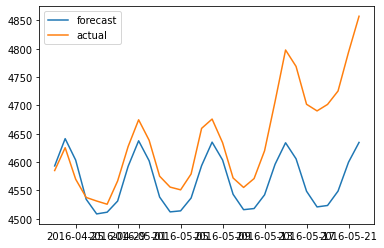

In [16]:
import matplotlib.pyplot as plt

plt.plot(df_results.index, df_results["store_sales_forecast"], label = "forecast")
plt.plot(df_test.index, df_test["store_sales"], label = "actual")
plt.legend()
plt.show()


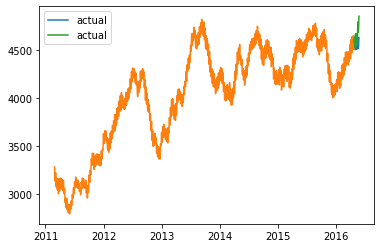

In [17]:
plt.plot(df_results["store_sales_forecast"].index, df_results["store_sales_forecast"], label = "actual")
plt.plot(df_original["store_sales"][0:-nobs].index, df_original["store_sales"][0:-nobs])
plt.plot(df_test.index, df_test["store_sales"], label = "actual")
plt.legend()
plt.show()

In [18]:
# evaluate the model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

error_mse = mean_squared_error(df_test["store_sales"], df_results["store_sales_forecast"])
error_mae = mean_absolute_error(df_test["store_sales"], df_results["store_sales_forecast"])
error_r2 = r2_score(df_test["store_sales"], df_results["store_sales_forecast"])
print("MSE:", error_mse)
print("MAE:", error_mae)
print("R2:", error_r2)


MSE: 10003.918680706462
MAE: 75.65186722288793
R2: -0.32644559896445613
